# extrapolating Samsung's gaps from screen-frame
## steps:
start from Samsung's template parameters, <br>
extrapolate to iPhone gap range, <br>
see how bignet's confidence react to such change.

## output:
in extrapolation/samsunng_gap, multiple (10000) SVGs from left->right
in extrapolation/samsunng_gap/trained_bignet1_naug_norm.pt,<br>
and gaps (rl.pkl, rs.pkl) - confidence (y.pkl) pair, which can also be found [here]()

In [4]:
import util as u
import numpy as np
import os
import copy

In [5]:
pkl_folder="pkl"
fig_folder="figure"

iphone_par=u.load_item("iphone_par.pkl")
samsung_par=u.load_item("samsung_par.pkl")

In [6]:
samsung_ref=u.samsung_interpolation\
(ratio=0.5, ct=1)

samsung_observe=copy.deepcopy(samsung_ref)

In [8]:
'''create a 2d array'''
import matplotlib.pyplot as plt
extra_folder="extrapolation"
samsung_folder=extra_folder+"/samsung_gap"
u.initialize([samsung_folder])
temp_seed=3

samsung_ref=u.samsung_interpolation\
(ratio=0.5, ct=1)
samsung_ref["sux"][0][0]=0
samsung_ref["m_ushift"][0][0]=0
samsung_ref["m_lshift"][0][0]=0
samsung_ref["suh"][0][0]=0
samsung_ref["slh"][0][0]=0
samsung_ref["camera_r1"][0][0]=1e-9

samsung_ref["rl"][0][0]=12 #6.52-8.31
samsung_ref["rm"][0][0]=10.5 # 6.52-8.03
samsung_ref["rs"][0][0]=10 # 4.89-6.97

samsung_observe=copy.deepcopy(samsung_ref)
data_size=(1,100)
target="rl"
# low, up = 10.6,12
low, up = 10.51,13
target2="rs"
# low2,up2 = 4,9.9
low2, up2 = 4,10.49

model_path="trained_bignet1_naug_norm.pt"
mode1="norm"

target_array=np.linspace(low, up, data_size[1])
target_array2=np.linspace(low2, up2, data_size[1])

norm_pred_rec=[]
avg_pred_rec=[]

for jdx, j in enumerate(target_array2):
    current_samsung_folder=samsung_folder+"/rs %s"%j
    for idx,i in enumerate(samsung_observe):
        if i=="button_h":
            samsung_observe[i]=0.75
        elif samsung_ref[i][0][0]==None:
            samsung_observe[i]=np.zeros(data_size)
        elif i==target:
            samsung_observe[i]=\
            np.expand_dims(target_array,0)
        elif i==target2:
            samsung_observe[i]=\
            samsung_observe[i]=np.ones(data_size)*j
        else:
            samsung_observe[i]=np.ones(data_size)*samsung_ref[i][0][0]

    u.create_samsung_dataset(samsung_observe, current_samsung_folder,\
                  draw_nodes=0, stroke_aug=0, stripe=0, extra=1)

    samsung_path=u.get_filelist(dir,current_samsung_folder)

    #exclude the generated other curves
    exclude_group=[ x for x in samsung_path if "group" not in x ]
    exclude=[ x for x in exclude_group if "curve" not in x ]
    exclude_sorted=u.sort_list(exclude)
    current_norm_pred_rec=[]
    current_avg_pred_rec=[]
    
    for pic_path in exclude_sorted:
        _, norm_samsung_pred=u.test1svg(model_path, pic_path, brand="samsung", resample=1,\
                    prediction=1, ablation=None,\
                    mode=mode1, temp_seed=temp_seed)
        current_norm_pred_rec.append(norm_samsung_pred[0][1])

    norm_pred_rec.append(current_norm_pred_rec)

In [10]:
u.dump_item(target_array, "%s/rl.pkl"%samsung_folder)
u.dump_item(target_array2, "%s/rs.pkl"%samsung_folder)
u.dump_item(norm_pred_rec, "%s/y.pkl"%samsung_folder)

In [11]:
target_array = u.load_item("%s/rl.pkl"%samsung_folder)
target_array2 = u.load_item("%s/rs.pkl"%samsung_folder)
norm_pred_rec = u.load_item("%s/y.pkl"%samsung_folder)

plot_3d_norm=np.array(norm_pred_rec)

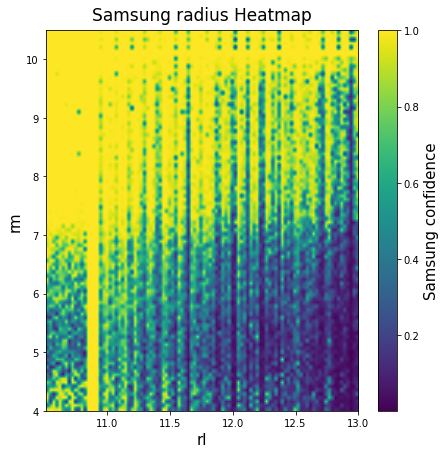

In [12]:
title="Samsung radius Heatmap"
rm=samsung_ref["rm"][0][0]#10.5
xmin=low-rm#10.6
xmax=up-rm #12
ymin=rm-up2#9.9
ymax=rm-low2#4
radius_axis=[low, up, low2, up2]
# low, up = 10.51,13
# low2, up2 = 4,10.4
gap_axis=[xmin, xmax, ymin, ymax]
plt.figure(figsize=(7, 7))
plt.imshow(plot_3d_norm, interpolation="bilinear",\
           extent=radius_axis, aspect='auto', origin='lower')
plt.xlabel("rl", fontsize=15)
plt.ylabel("rm", fontsize=15)
plt.title(title, fontsize=17, pad=10)
plt.colorbar().set_label(label="Samsung confidence", size=15)

plt.show()
# plt.imshow(avg_pred_rec, interpolation="bilinear")

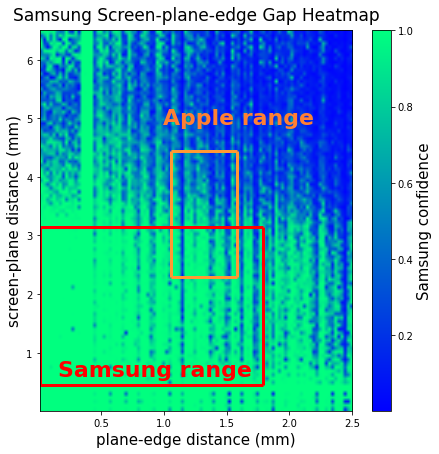

In [13]:
# x: rl->pl2edge
# y: rs->scr2pl
title="Samsung Screen-plane-edge Gap Heatmap"
rm=samsung_ref["rm"][0][0]#10.5
xmin=low-rm#10.6
xmax=up-rm #12
ymin=rm-up2#9.9
ymax=rm-low2#4
radius_axis=[low, up, low2, up2]
gap_axis=[xmin, xmax, ymin, ymax]
plt.figure(figsize=(7, 7))
plt.imshow(plot_3d_norm, interpolation="bilinear",\
           extent=gap_axis, aspect='auto', cmap="winter")
plt.xlabel("plane-edge distance (mm)", fontsize=15)
plt.ylabel("screen-plane distance (mm)", fontsize=15)
plt.colorbar().set_label(label="Samsung confidence", size=15)
plt.title(title, fontsize=17, pad=10)

xmin=1/146.15*154.55
xmax=1.5/146.15*154.55
ymin=2.17/146.15*154.55
ymax=4.2/146.15*154.55

plt.vlines(xmin, ymin, ymax, color=[1,0.6,0.2],linewidth=3)
plt.vlines(xmax, ymin, ymax, color=[1,0.6,0.2],linewidth=3)
plt.hlines(ymin, xmin, xmax, color=[1,0.6,0.2],linewidth=3)
plt.hlines(ymax, xmin, xmax, color=[1,0.6,0.2],linewidth=3)


xmin2=0.01
xmax2=8.31-6.52
ymin2=6.97-6.52
ymax2=8.03-4.89
plt.vlines(xmin2, ymin2, ymax2, color=[1,0,0],linewidth=3)
plt.vlines(xmax2, ymin2, ymax2, color=[1,0,0],linewidth=3)
plt.hlines(ymin2, xmin2, xmax2, color=[1,0,0],linewidth=3)
plt.hlines(ymax2, xmin2, xmax2, color=[1,0,0],linewidth=3)

plt.text(1.7, 0.7, 'Samsung range', ha='right',\
         va='center', fontsize=22, color=[1,0.,0.], weight='bold')
plt.text(2.2, 5, 'Apple range', ha='right',\
         va='center', fontsize=22, color=[1,0.5,0.2], weight='bold')

plt.savefig("%s.jpg"%title)
plt.show()